In [1]:
from qutip import*
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize

In [13]:
# System
N = 20

Iq = qeye(2)
Ic = qeye(N)
a = destroy(N)
n = a.dag()*a

t1 = 200
gamma_a_loss = 1 / t1  # t1 = 100mu s
a_loss = np.sqrt(gamma_a_loss) * destroy(N)

def U_ideal_operator(u_k: float):
    P = (1j*(a.dag()-a))/2
    Uk = (1j*u_k*P*sx).expm()
    return Uk

vac = tensor(fock(2,0),fock(N,0))




### Functions

# calculate time evolution of a given state
def lossy_channel(state, t_list):
    rhos_loss = mesolve(Ic,state, t_list, c_ops = a_loss).states
    return rhos_loss

# find the min value of the wigner function, assuming the blobs are align on the X axis
def wigner_negativiy(state):
    yvec = np.linspace(-2,2,101) # guarantees that yvec has 0.0
    W = wigner(state,0, yvec, g = 2)
    return np.min(W[:,0])*np.pi/2 # normalize to 1

# send the states through the channel, find their respective wigner and store the results in a nested list negativity_loss[0] -> result for states[0]
def get_data(states, t_list):
    negativity_loss=[]
    for i in range(len(states)):
        negativity_loss.append([])
        state = states[i]
        rhos_loss = lossy_channel(state,t_list)
        for rho in rhos_loss:
            negativity = wigner_negativiy(rho)
            negativity_loss[i].append(negativity)
        
            
    return negativity_loss

# used to turn t1 into the evolution time into a transmission value
def transmission (t):
    return np.exp(-t/t1)

def relative_to_t1(t):
    return t/t1

def calc_squeez_parameter(dB):
    return np.log(10**(dB/10))/2


# getting the squeezed cat states with matched overlap
def overlap_squeezed(beta, alpha, squeezing_parameter_db):
    squeezing_parameter = calc_squeez_parameter(squeezing_parameter_db)
    coherent_overlap = coherent(N,alpha).overlap(coherent(N,-alpha))
    squeezed_overlap = (displace(N,beta[0])*squeeze(N,squeezing_parameter)*coherent(N,0)).overlap((displace(N,-beta[0])*squeeze(N,squeezing_parameter)*coherent(N,0)))
    return np.abs(coherent_overlap-squeezed_overlap)

# need to insert sensible guesses for beta0
def find_beta_squeezed(beta0, alpha, dB):
    result = optimize.minimize(overlap_squeezed, 0.5,  args=(alpha, dB),  method= 'Powell', options={'gtol': 1e-8, 'disp': True})
    fitted_params = result.x
    return fitted_params

def state_creation_same_overlap(alpha, squeezing_array_db):
    states = []
    print(alpha)
    for db in squeezing_array_db:
        beta = find_beta_squeezed(alpha, alpha, db)[0]
        print(f" {db}dB - beta {beta}")
        squeezed_cat = ((displace(N,beta)-displace(N,-beta))*squeeze(N,calc_squeez_parameter(db))*coherent(N,0)).unit()
        states.append(squeezed_cat)
    return states

The squeezing parameter s results into a decrease/increase of the quadratures by the facor 
$e^{-2s}$/$e^{2s}$, respectively. This is used to calculate a wanted dB value into a squeezing parameter.

### Initialize States

In [14]:
### States
alpha = 1.8
cat = (coherent(N,alpha) - coherent(N,-alpha)).unit()

dBs = [0,3, 6, 9, 12]

# first squeezed vacuum, then cat
states1 = [((displace(N,alpha)-displace(N,-alpha))*squeeze(N,calc_squeez_parameter(db))*coherent(N,0)).unit() for db in dBs]


# first cat, then squeeze
states2 = [squeeze(N,calc_squeez_parameter(i))for i in dBs]*cat

# squeezed states that have the same overlap as the coherent state.
#states3 = state_creation_same_overlap(alpha,dBs)

In [15]:
beta = 0.501
db = 6

print(coherent(N,alpha).overlap(coherent(N,-alpha)))
print((displace(N,beta)*squeeze(N,calc_squeez_parameter(db))*coherent(N,0)).overlap((displace(N,-beta)*squeeze(N,calc_squeez_parameter(db))*coherent(N,0))))


(0.001533808443084972+0j)
(0.13554765211584338+0j)


In [16]:
# time evolution span
ts = np.linspace(0,70, 15) # values are chosen such that we are between transmission of 0.5 (70) and 1 (0.1)

# get the wigner negativity of the state for each point in time
negativity_loss1 = get_data(states1, ts)
negativity_loss2 = get_data(states2, ts)
#negativity_loss3 = get_data(states3, ts)

# use to plot the negativity vs "transmission" exp(-t/T1)
transmis = []
for i in ts:
    transmis.append(transmission(i))

# calculate points in time as fraction of T1 
rel_t1 = []
for i in ts:
    rel_t1.append(relative_to_t1(i))


In [17]:
np.savez('wigner_negativity.npz', rel_t1=rel_t1, negativity_loss2=negativity_loss2)

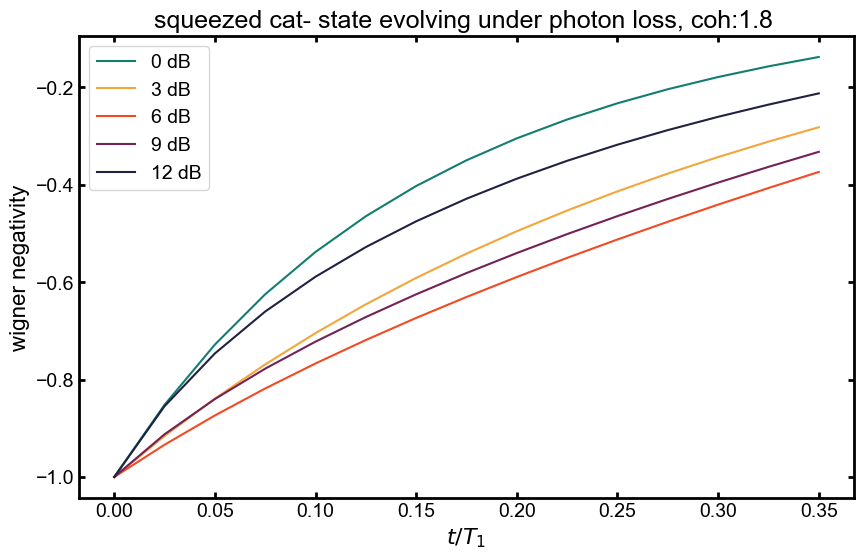

In [18]:
colours = [([0.07, 0.49, 0.44]),
 ([0.95, 0.65, 0.23]),
 ([0.95, 0.29, 0.14]),
 ([0.45, 0.13, 0.34]),
 ([0.13, 0.13, 0.26])]

import matplotlib as mpl
mpl.rcParams['legend.loc'] = 'best'
mpl.rcParams["axes.linewidth"] = 2.0
mpl.rcParams['legend.frameon'] = True

mpl.rcParams['font.sans-serif'] ='Arial'
mpl.rcParams['axes.labelsize']= 8
mpl.rcParams['legend.fontsize'] = 14

fig, ax = plt.subplots(figsize = (10,6))

ax.tick_params(direction = "in", bottom=True, top=True, left=True, right=True, length=4, width=2, labelsize = 14)
#ax.grid();

#general_figure()plt.plot(transmis,negativity_loss[0], 'o', label = '0')
ax.plot(rel_t1,negativity_loss2[0],  color = colours[0], label = '0 dB')
ax.plot(rel_t1,negativity_loss2[1],  color = colours[1],label = '3 dB')
ax.plot(rel_t1,negativity_loss2[2],  color = colours[2],label = '6 dB')
ax.plot(rel_t1,negativity_loss2[3], color = colours[3],label = '9 dB')
ax.plot(rel_t1,negativity_loss2[4],  color = colours[4],label = '12 dB')
# ax.plot(rel_t1,negativity_loss2[4], '--^', color = '#073b4c',label = '8 dB')
# ax.plot(rel_t1,negativity_loss2[5], '--v', color = '#118ab2',label = '10 dB')

ax.set_xlim()

ax.set_title(f"squeezed cat- state evolving under photon loss, coh:{alpha} ", fontsize=18)
#ax.set_title(f"cat- state with different degrees of squeezing different alpha, but same state overlap under loss", fontsize=18)
ax.set_xlabel(r"$t/T_1$", fontsize=16)
ax.set_ylabel("wigner negativity", fontsize=16)

ax.legend()
plt.savefig("squeezed cat under photon loss.pdf", dpi=1200)

## Make it pretty

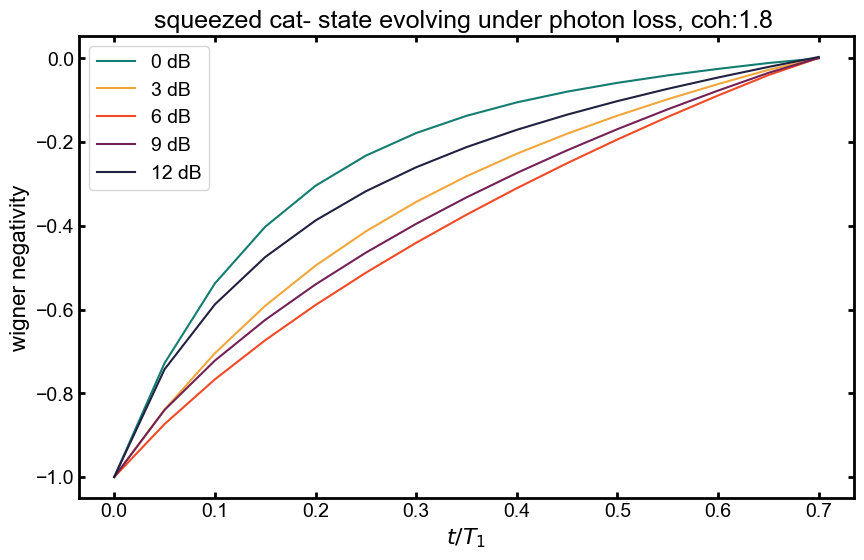

In [6]:
colours = [([0.07, 0.49, 0.44]),
 ([0.95, 0.65, 0.23]),
 ([0.95, 0.29, 0.14]),
 ([0.45, 0.13, 0.34]),
 ([0.13, 0.13, 0.26])]

import matplotlib as mpl
mpl.rcParams['legend.loc'] = 'best'
mpl.rcParams["axes.linewidth"] = 2.0
mpl.rcParams['legend.frameon'] = True

mpl.rcParams['font.sans-serif'] ='Arial'
mpl.rcParams['axes.labelsize']= 8
mpl.rcParams['legend.fontsize'] = 14

fig, ax = plt.subplots(figsize = (10,6))

ax.tick_params(direction = "in", bottom=True, top=True, left=True, right=True, length=4, width=2, labelsize = 14)
#ax.grid();

#general_figure()plt.plot(transmis,negativity_loss[0], 'o', label = '0')
ax.plot(rel_t1,negativity_loss2[0],  color = colours[0], label = '0 dB')
ax.plot(rel_t1,negativity_loss2[1],  color = colours[1],label = '3 dB')
ax.plot(rel_t1,negativity_loss2[2],  color = colours[2],label = '6 dB')
ax.plot(rel_t1,negativity_loss2[3], color = colours[3],label = '9 dB')
ax.plot(rel_t1,negativity_loss2[4],  color = colours[4],label = '12 dB')
# ax.plot(rel_t1,negativity_loss2[4], '--^', color = '#073b4c',label = '8 dB')
# ax.plot(rel_t1,negativity_loss2[5], '--v', color = '#118ab2',label = '10 dB')

ax.set_xlim()

ax.set_title(f"squeezed cat- state evolving under photon loss, coh:{alpha} ", fontsize=18)
#ax.set_title(f"cat- state with different degrees of squeezing different alpha, but same state overlap under loss", fontsize=18)
ax.set_xlabel(r"$t/T_1$", fontsize=16)
ax.set_ylabel("wigner negativity", fontsize=16)

ax.legend()
plt.savefig("squeezed cat under photon loss.pdf", dpi=1200)

## Wigners


KeyboardInterrupt: 

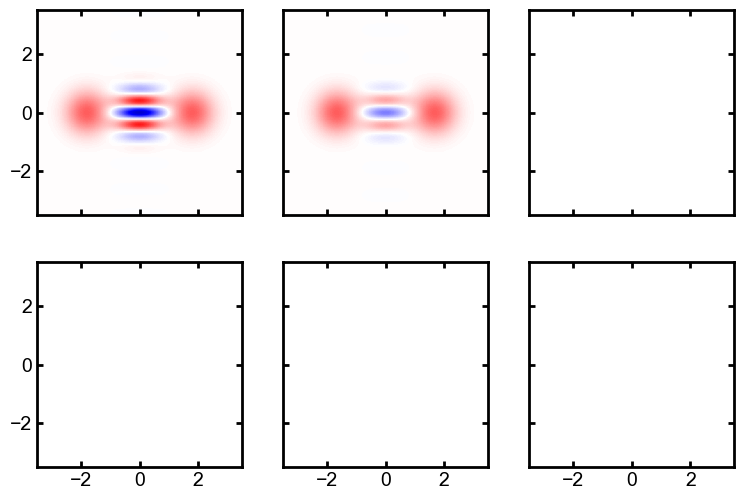

In [7]:
rho_cat = mesolve(qeye(N),states2[0], ts, c_ops = a_loss).states
rho_squeezed = mesolve(qeye(N),states2[3], ts, c_ops = a_loss).states

fig, axs = plt.subplots(2,3, figsize = (9,6), sharex = True, sharey = True)



xvec = np.linspace(-3.5,3.5,500)
yvec = np.linspace(-3.5,3.5,500)
X, Y = np.meshgrid(xvec, yvec)
xticks = np.linspace(-2, 2, 3)
for ax_row in axs:
        for ax in ax_row:
                ax.tick_params(direction = "in", bottom=True, top=True, left=True, right=True, length=4, width=2, labelsize = 14)
                ax.set_aspect("equal", adjustable="box")
                ax.set_xticks(xticks)
# axs[0][0].set_aspect("equal", adjustable="box")
# axs[0][1].set_aspect("equal", adjustable="box")
# axs[0][2].set_aspect("equal", adjustable="box")
# axs[1][0].set_aspect("equal", adjustable="box")
# axs[1][1].set_aspect("equal", adjustable="box")
# axs[1][2].set_aspect("equal", adjustable="box")


pcm = axs[0][0].pcolormesh(xvec,yvec, wigner(rho_cat[0],xvec, yvec, g = 2),linewidth=0, rasterized=True,cmap = "seismic", shading='auto',  vmin=-1, vmax=+1
        )
axs[0][1].pcolormesh(xvec,yvec, wigner(rho_cat[3],xvec, yvec, g = 2),linewidth=0, rasterized=True,cmap = "seismic",shading='auto',vmin=-1, vmax=+1
        )
axs[0][2].pcolormesh(xvec,yvec, wigner(rho_cat[14],xvec, yvec, g = 2),linewidth=0, rasterized=True,cmap = "seismic",shading='auto', vmin=-1, vmax=+1
        )
axs[1][0].pcolormesh(xvec,yvec, wigner(rho_squeezed[0],xvec, yvec, g = 2),linewidth=0, rasterized=True,cmap = "seismic",shading='auto', vmin=-1, vmax=+1
        )
axs[1][1].pcolormesh(xvec,yvec, wigner(rho_squeezed[3],xvec, yvec, g = 2),linewidth=0, rasterized=True,cmap = "seismic",shading='auto', vmin=-1, vmax=+1
        )
axs[1][2].pcolormesh(xvec,yvec, wigner(rho_squeezed[14],xvec, yvec, g = 2),linewidth=0, rasterized=True,cmap = "seismic",shading='auto', vmin=-1, vmax=+1
        )

# titles
fig.suptitle("Cat and 9dB Squeezed Cat with same overlap evovle under photon loss", fontsize=18)
axs[0][0].set_title(r"$t/T_1 = 0$", fontsize=16)
axs[0][1].set_title(r"$t/T_1 = 0.1.5$", fontsize=16)
axs[0][2].set_title(r"$t/T_1 = 0.7$", fontsize=16)
# axs[0][2].set_aspect("equal", adjustable="box")
# axs[1][0].set_aspect("equal", adjustable="box")
# axs[1][1].set_aspect("equal", adjustable="box")
# axs[1][2].set_aspect("equal", adjustable="box")
fig.tight_layout()
fig.colorbar(pcm, ax=axs.ravel().tolist(), shrink = 1)

plt.savefig("Cat Wigners under photon loss.pdf", dpi=1200)

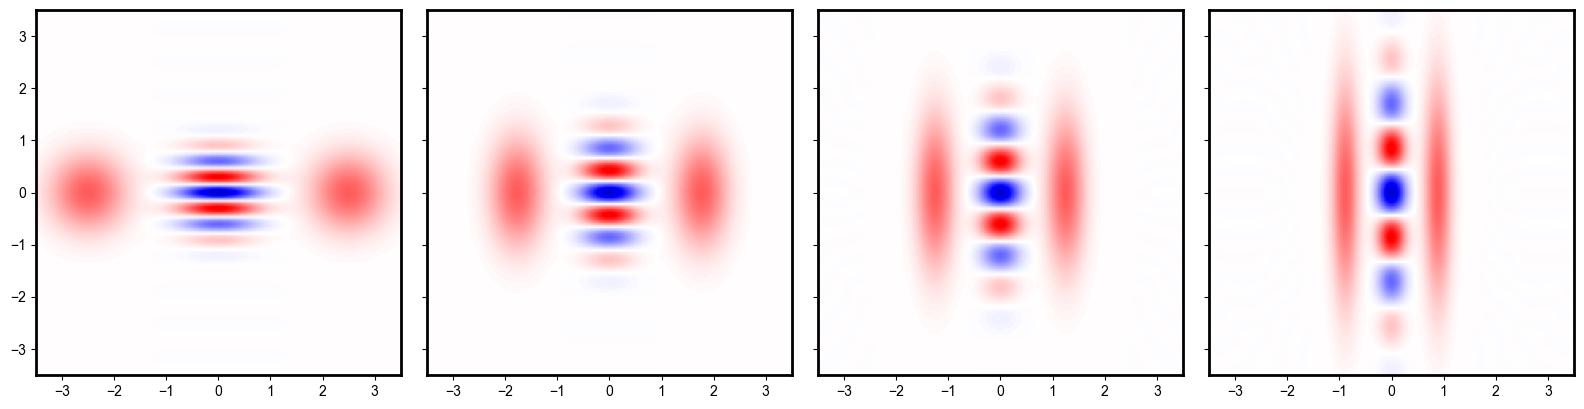

In [50]:
rho_cat = mesolve(qeye(N),states2[0], ts, c_ops = a_loss).states
rho_sq3 = mesolve(qeye(N),states2[1], ts, c_ops = a_loss).states
rho_sq6 = mesolve(qeye(N),states2[2], ts, c_ops = a_loss).states
rho_sq9 = mesolve(qeye(N),states2[3], ts, c_ops = a_loss).states

fig, axs = plt.subplots(1,4, figsize = (16,4), sharex = True, sharey = True)



xvec = np.linspace(-3.5,3.5,500)
yvec = np.linspace(-3.5,3.5,500)
X, Y = np.meshgrid(xvec, yvec)
xticks = np.linspace(-2, 2, 3)

axs[0].set_aspect("equal", adjustable="box")
axs[1].set_aspect("equal", adjustable="box")
axs[2].set_aspect("equal", adjustable="box")
axs[3].set_aspect("equal", adjustable="box")



pcm = axs[0].pcolormesh(xvec,yvec, wigner(rho_cat[0],xvec, yvec, g = 2),linewidth=0, rasterized=True,cmap = "seismic", shading='auto',  vmin=-1, vmax=+1
        )
axs[1].pcolormesh(xvec,yvec, wigner(rho_sq3[0],xvec, yvec, g = 2),linewidth=0, rasterized=True,cmap = "seismic",shading='auto',vmin=-1, vmax=+1
        )
axs[2].pcolormesh(xvec,yvec, wigner(rho_sq6[0],xvec, yvec, g = 2),linewidth=0, rasterized=True,cmap = "seismic",shading='auto', vmin=-1, vmax=+1
)
axs[3].pcolormesh(xvec,yvec, wigner(rho_sq9[0],xvec, yvec, g = 2),linewidth=0, rasterized=True,cmap = "seismic",shading='auto', vmin=-1, vmax=+1
)

# titles
# axs[0][2].set_aspect("equal", adjustable="box")
# axs[1][0].set_aspect("equal", adjustable="box")
# axs[1][1].set_aspect("equal", adjustable="box")
# axs[1][2].set_aspect("equal", adjustable="box")
fig.tight_layout()

plt.savefig("different squeezing.pdf", dpi=1200)

In [45]:
for i in range(len(states2)):
    print(expect(n,states2[i]))

6.250046583338253
3.25659074379636
2.1280926832711904
2.3043065121442368


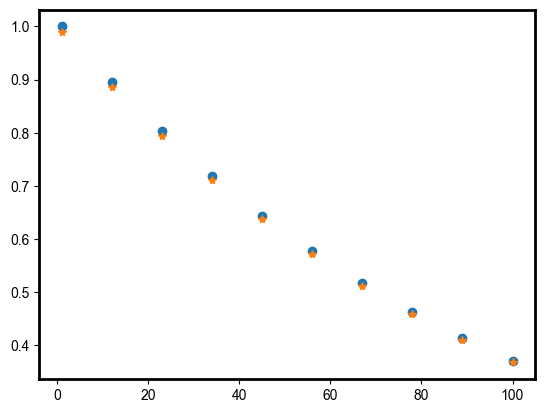

In [40]:
# I wrote this to check out if my time evolution has the same result as the exponential decay expected from T1, turns out, loss is to be written without as 1/T1 instead of 1/T1 *2pu=i
fock1 = fock(N,1)

wait_times = np.linspace(1,100,10)
photon_number = []
exp_fac = []

state1 = lossy_channel(fock1,wait_times)
photon_number.append(expect((destroy(N).dag()*destroy(N)),state1))
for t in wait_times:
    exp_fac.append(np.exp(-t/t1))

plt.plot(wait_times, photon_number[0], 'o')
plt.plot(wait_times, exp_fac, '*')

In [39]:
exp_fac

[0.9900498337491681]